In [1]:
from __future__ import division, print_function
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import pandas as pd
import os
from itertools import combinations
%matplotlib inline
import matplotlib.pylab as plt

Using TensorFlow backend.
/Users/reubenfeinman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# First, test VGG similarity scores on generated artificial images

In [2]:
def load_imgs(save_folder, target_size, mode='vgg'):
    assert mode in ['vgg', 'custom']
    imgs = []
    files = [file for file in os.listdir(save_folder) if file.endswith('png')]
    files = sorted(files)
    for file in files:
        img_path = os.path.join(save_folder, file)
        img = image.load_img(img_path, target_size=target_size, interpolation='bicubic')
        imgs.append(image.img_to_array(img))
    imgs = np.asarray(imgs)
    if mode == 'vgg':
        return preprocess_input(imgs)
    else:
        imgs /= 255.
        return imgs

In [5]:
data_folder = '../data/images_generated/images_ca0015_ex0010'
X_gen_vgg = load_imgs(data_folder, target_size=(224, 224), mode='vgg')

In [6]:
print('Max: ', X_gen_vgg.max())
print('Min: ', X_gen_vgg.min())
print('Mean: ', X_gen_vgg.mean())

Max:  151.061
Min:  -123.68
Mean:  95.0615


In [7]:
X_gen_custom = load_imgs(data_folder, target_size=(224, 224), mode='custom')

In [9]:
df_gen = pd.read_csv(os.path.join(data_folder,'data.csv'), index_col=0)
shapes_gen = df_gen['shape'].as_matrix()
colors_gen = df_gen['color'].as_matrix()
textures_gen = df_gen['texture'].as_matrix()

In [10]:
model = VGG16(weights='imagenet', include_top=True)
model.layers

In [11]:
from scipy.spatial.distance import cosine

def similarity(x1, x2):
    return 1 - cosine(x1, x2)

def similarity_t(tuple):
    x1, x2 = tuple
    return similarity(x1, x2)

In [12]:
from learning2learn.util import get_hidden_representations

def compute_representations(model, X, layer_num, batch_size=256):
    X_h = get_hidden_representations(model, X, layer_num, batch_size)
    return X_h.reshape(len(X_h), -1)

In [16]:
X_gen_hidden = compute_representations(model, X_gen_vgg, -3)
X_gen_hidden.shape

(165, 4096)

In [17]:
def plot_two(x1, x2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    axes[0].imshow(x1)
    axes[0].axis('off')
    axes[1].imshow(x2)
    axes[1].axis('off')
    plt.show()
    
def compare(X, X_h, i, j):
    print('Similarity: %0.3f' % similarity(X_h[i], X_h[j]))
    plot_two(X[i], X[j])
    print('\n')

### Similarities of sample 1 w/ other samples of same shape

In [18]:
def compare_similarities(X_custom, X_hidden, feature, i):
    """
    :param X_custom: The (nb_samples, width, height, 3) images, with pixel values 0-1
    :param X_hidden: The (nb_samples, nb_features) VGG features; corresponding to the images
    :param feature: The (nb_samples, ) array of either {shape, texture, color} values
    :param i: The baseline sample index
    """
    f = feature[i]
    inds_same = np.where(feature == f)[0]
    for j in inds_same:
        compare(X_custom, X_hidden, i, j)

In [72]:
inds_same = np.where(shapes_gen == shapes_gen[0])[0]

In [74]:
df_gen.iloc[inds_same]

,shape,color,texture
0,0,2,1
1,0,11,6
2,0,10,2
3,0,12,13
4,0,11,13
5,0,2,11
6,0,6,8
7,0,9,9
8,0,13,8
9,0,4,5


Similarity: 1.000


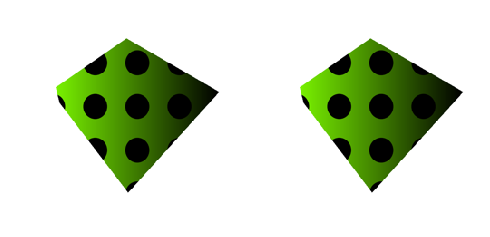



Similarity: 0.586


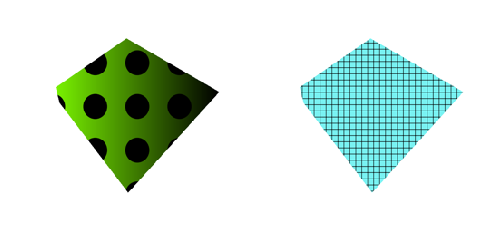



Similarity: 0.737


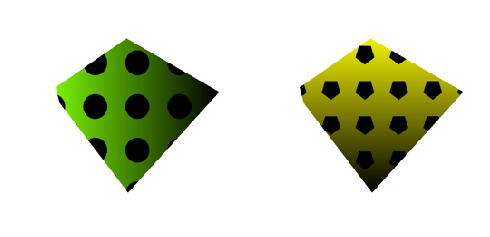



Similarity: 0.621


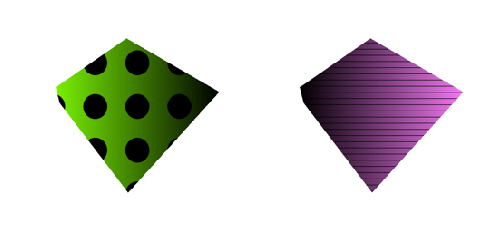



Similarity: 0.614


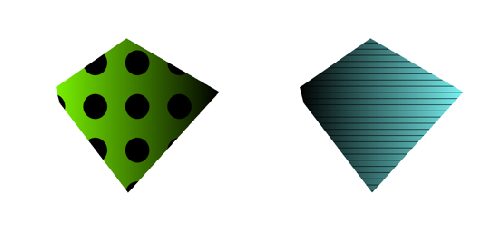



Similarity: 0.584


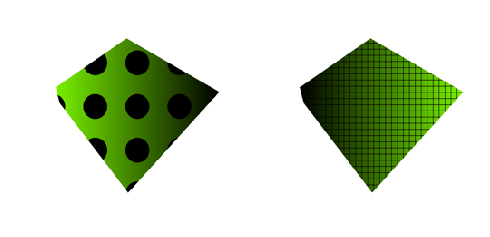



Similarity: 0.764


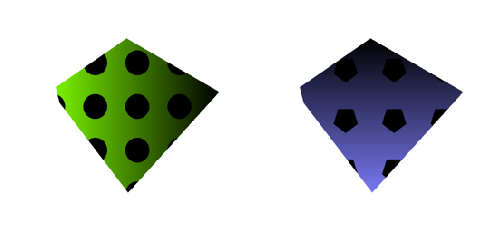



Similarity: 0.755


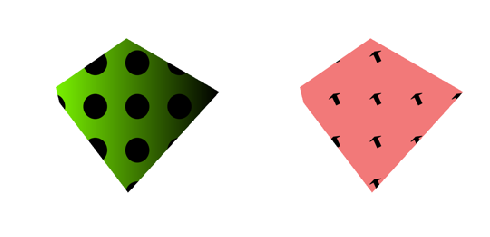



Similarity: 0.676


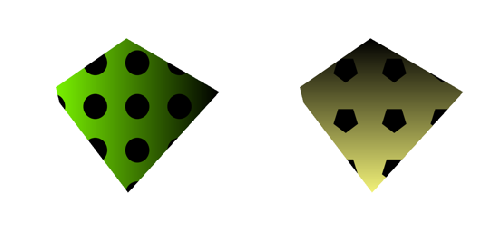



Similarity: 0.813


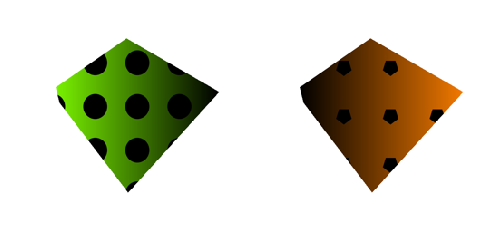



Similarity: 0.869


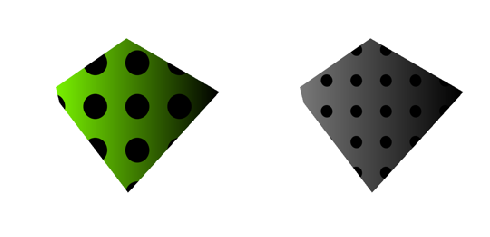

In [19]:
compare_similarities(X_gen_custom, X_gen_hidden, shapes_gen, 0)

### Similarities of sample 1 w/ other samples of same texture

Similarity: 1.000


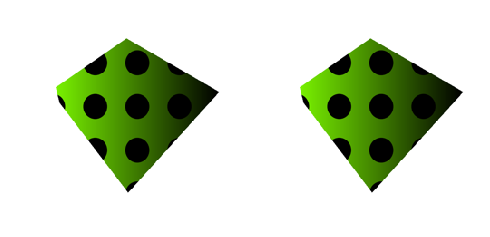



Similarity: 0.852


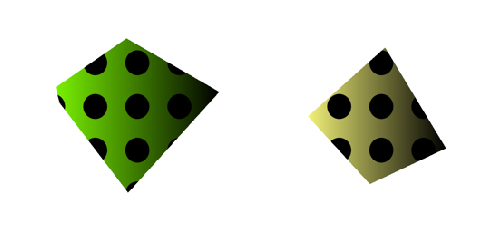



Similarity: 0.842


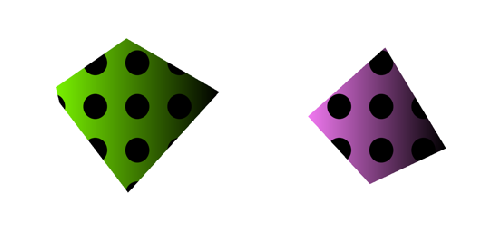



Similarity: 0.870


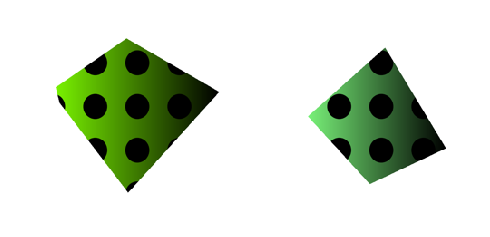



Similarity: 0.861


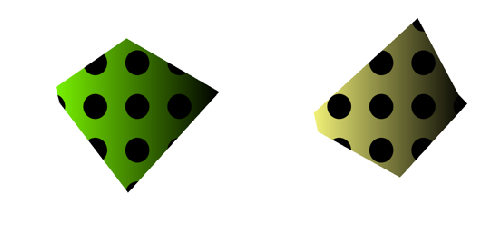



Similarity: 0.900


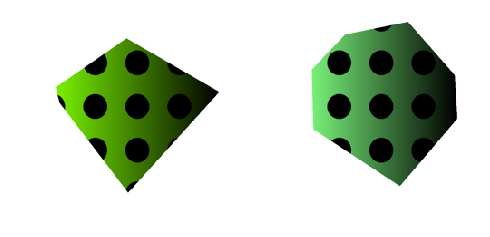



Similarity: 0.769


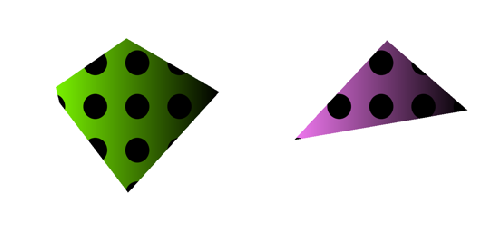



Similarity: 0.632


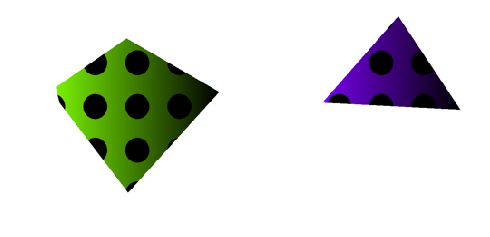



Similarity: 0.877


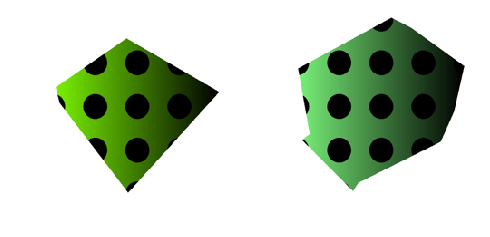



Similarity: 0.893


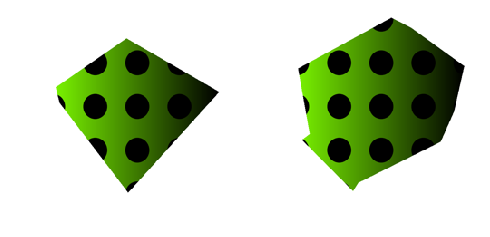



Similarity: 0.892


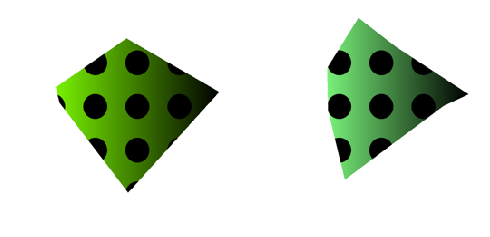

In [20]:
compare_similarities(X_gen_custom, X_gen_hidden, textures_gen, 0)

# Now, test VGG similarity scores on the artist images

In [21]:
from sklearn.preprocessing import LabelEncoder

def load_artist_imgs(save_folder, target_size, mode='vgg'):
    assert mode in ['vgg', 'custom']
    shapes = []
    colors = []
    textures = []
    imgs = []
    files = [file for file in os.listdir(save_folder) if file.endswith('jpg') or file.endswith('png')]
    for file in files:
        shape, texture, color = file.split('_')
        color = color[:-4]
        shapes.append(shape)
        textures.append(texture)
        colors.append(color)
        img_path = os.path.join(save_folder, file)
        img = image.load_img(img_path, target_size=target_size)
        imgs.append(image.img_to_array(img))
        
    le = LabelEncoder()
    shapes = le.fit_transform(shapes)
    colors = le.fit_transform(colors)
    textures = le.fit_transform(textures)
    
    imgs = np.asarray(imgs)
    if mode == 'vgg':
        imgs = preprocess_input(imgs)
    else:
        imgs /= 255.
    return imgs, shapes, colors, textures

In [22]:
data_folder = '/Users/reubenfeinman/Dropbox/NYU/brenden_lake/learning-to-learn/data/images_artist/'
X_artist_vgg, shapes_artist, colors_artist, textures_artist = load_artist_imgs(data_folder, target_size=(224, 224), mode='vgg')
X_artist_custom, _, _, _ = load_artist_imgs(data_folder, target_size=(224, 224), mode='custom')

In [23]:
print('Max: ', X_artist_vgg.max())
print('Min: ', X_artist_vgg.min())
print('Mean: ', X_artist_vgg.mean())

Max:  151.061
Min:  -123.68
Mean:  116.849


In [24]:
X_artist_hidden = compute_representations(model, X_artist_vgg, -3)
X_artist_hidden.shape

(80, 4096)

### Similarities of sample 1 w/ other samples of same shape

Similarity: 1.000


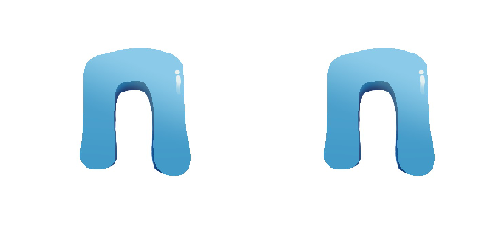



Similarity: 0.931


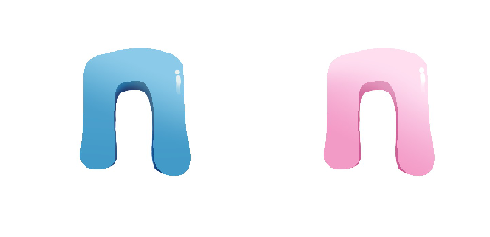



Similarity: 0.932


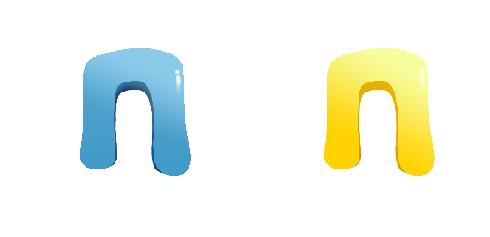



Similarity: 0.944


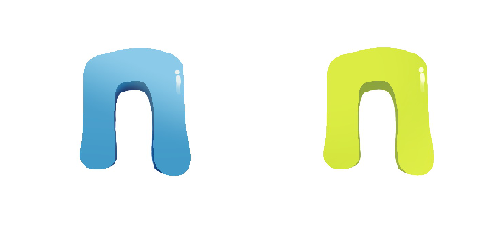



Similarity: 0.877


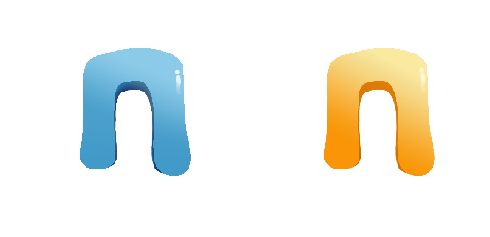



Similarity: 0.733


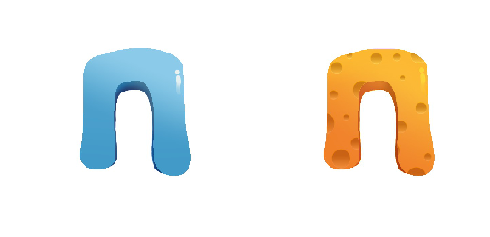



Similarity: 0.726


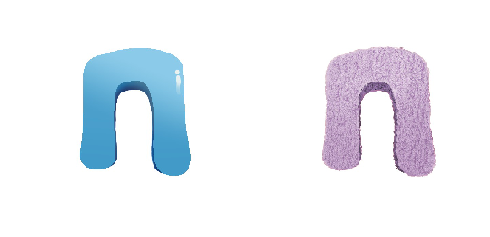



Similarity: 0.754


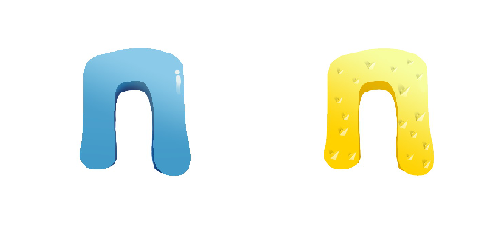



Similarity: 0.819


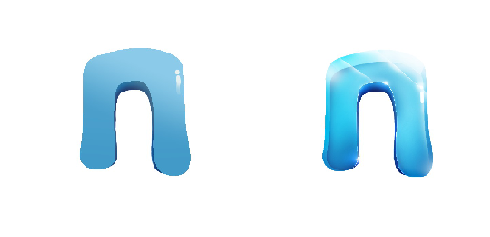



Similarity: 0.766


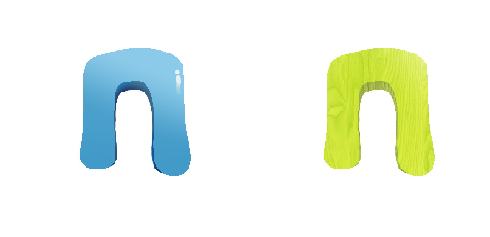



Similarity: 0.919


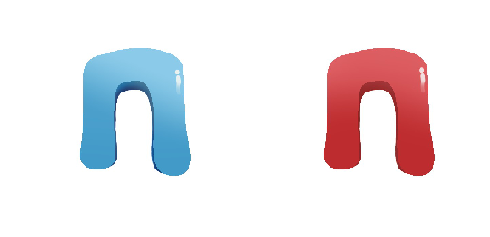



Similarity: 0.945


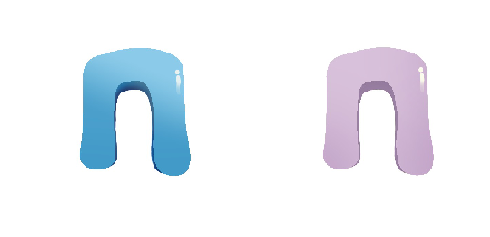

In [25]:
compare_similarities(X_artist_custom, X_artist_hidden, shapes_artist, 1)

### Similarities of sample 1 w/ other samples of same texture

Similarity: 1.000


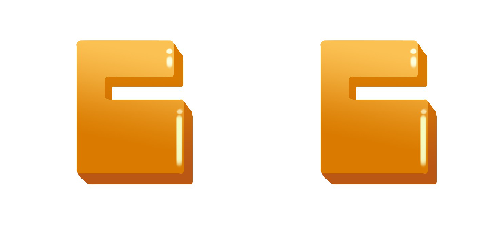



Similarity: 0.415


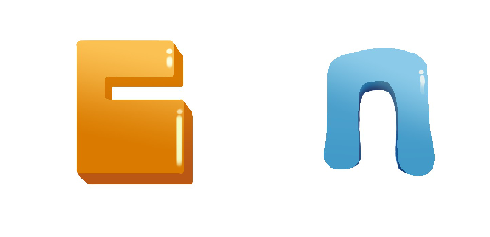



Similarity: 0.454


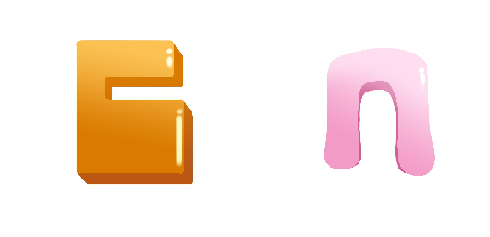



Similarity: 0.505


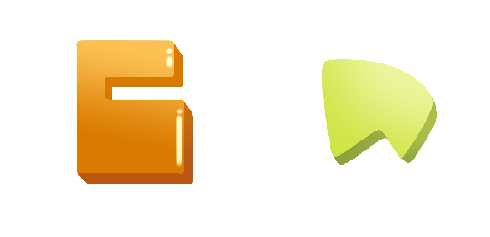



Similarity: 0.636


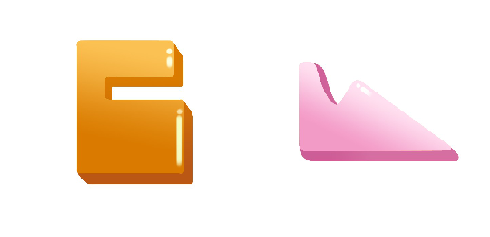



Similarity: 0.564


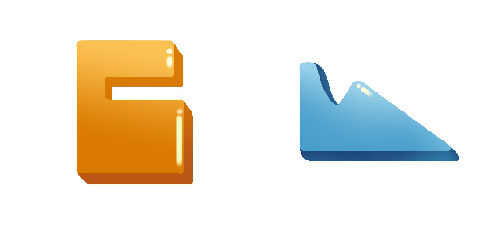



Similarity: 0.598


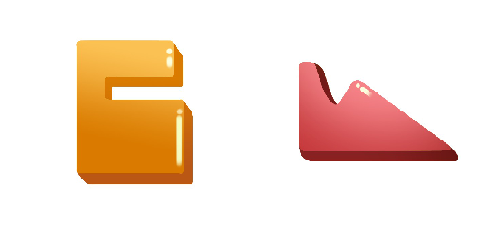



Similarity: 0.653


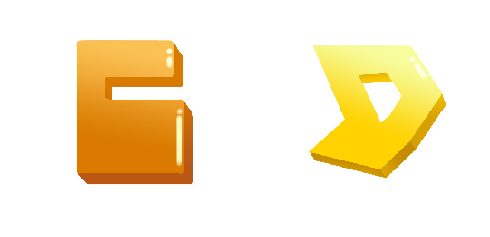



Similarity: 0.435


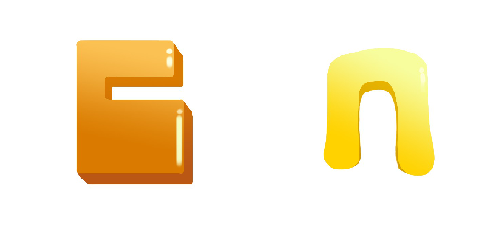



Similarity: 0.488


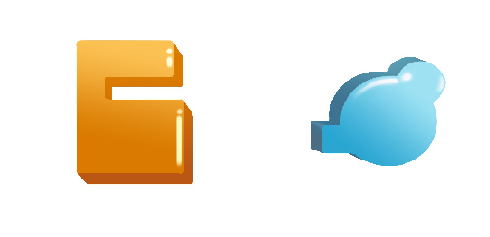



Similarity: 0.540


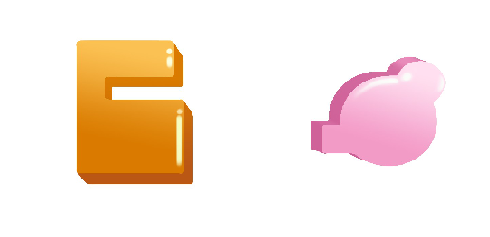



Similarity: 0.849


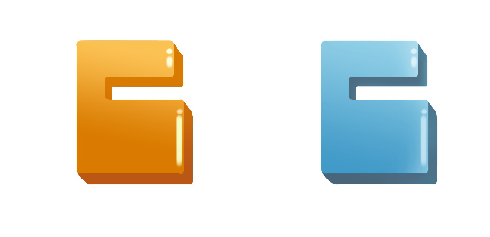



Similarity: 0.665


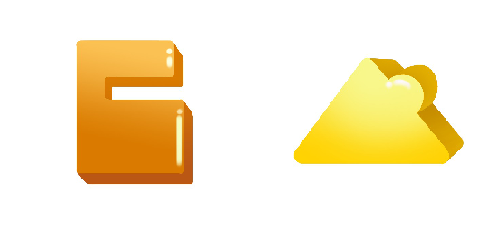



Similarity: 0.429


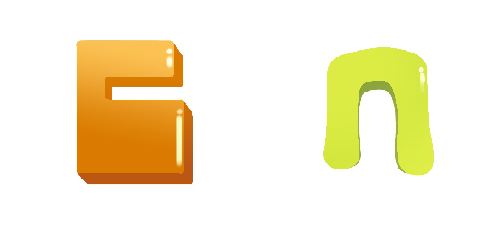



Similarity: 0.861


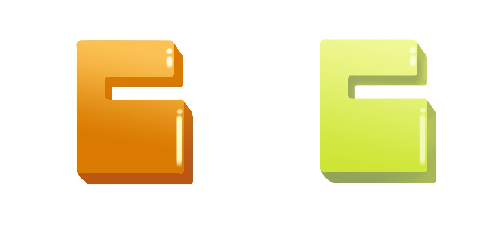



Similarity: 0.630


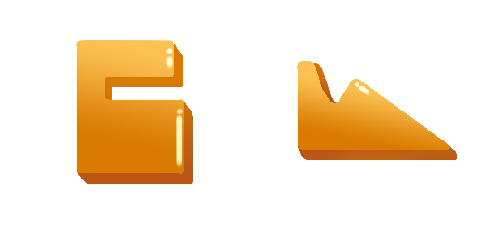



Similarity: 0.485


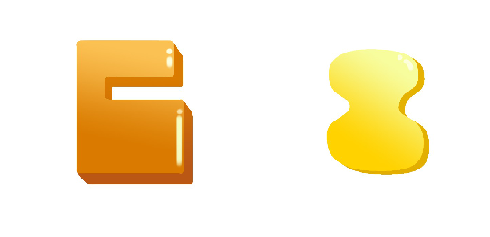



Similarity: 0.636


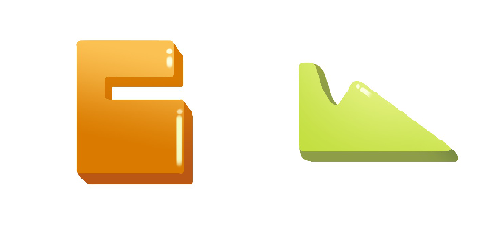



Similarity: 0.549


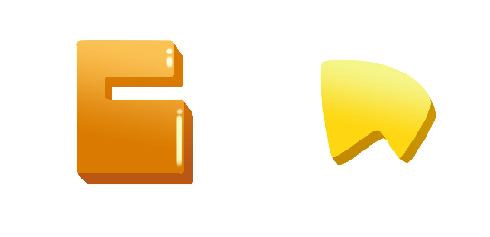



Similarity: 0.902


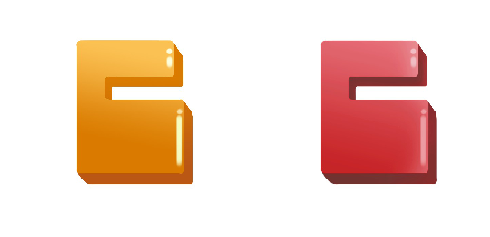



Similarity: 0.549


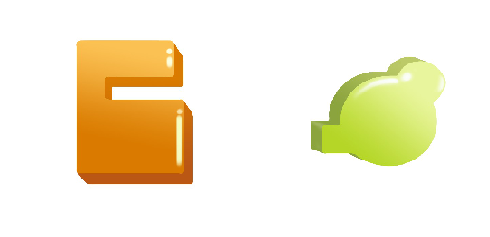



Similarity: 0.631


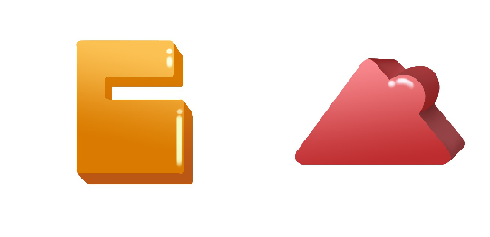



Similarity: 0.559


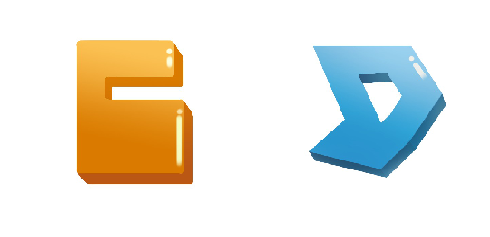



Similarity: 0.567


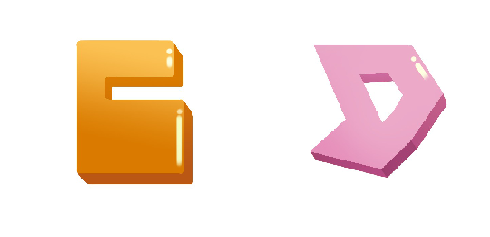



Similarity: 0.538


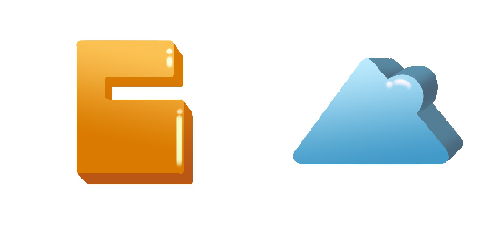



Similarity: 0.867


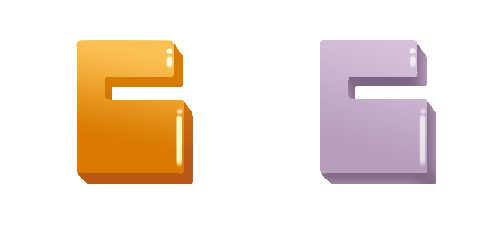



Similarity: 0.685


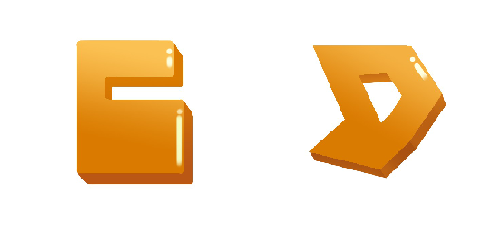



Similarity: 0.437


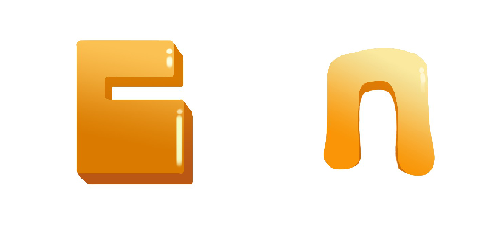



Similarity: 0.516


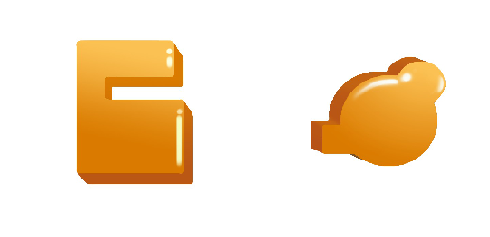



Similarity: 0.399


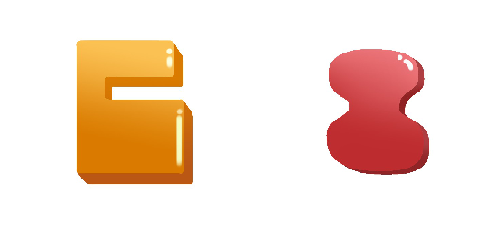



Similarity: 0.674


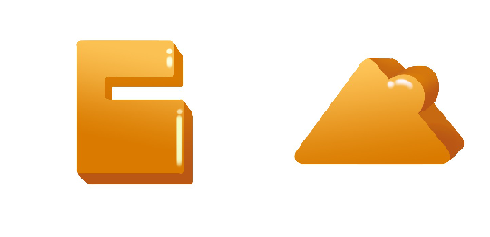



Similarity: 0.430


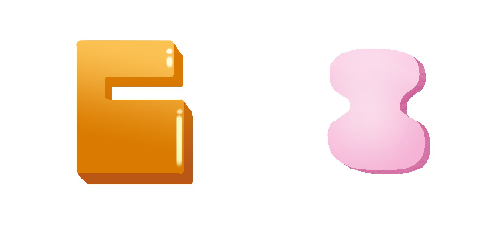



Similarity: 0.355


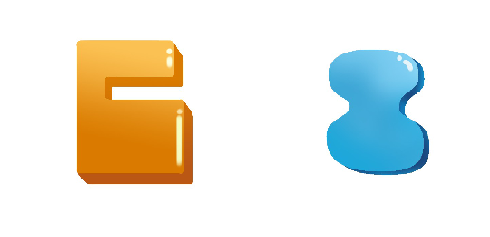



Similarity: 0.592


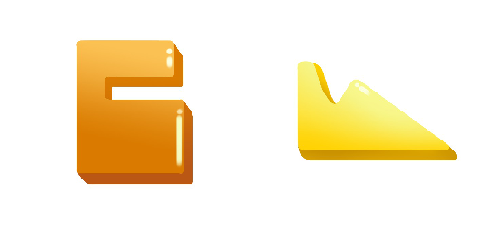



Similarity: 0.591


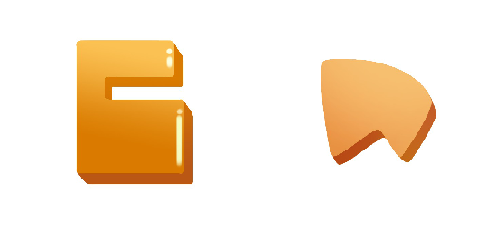



Similarity: 0.601


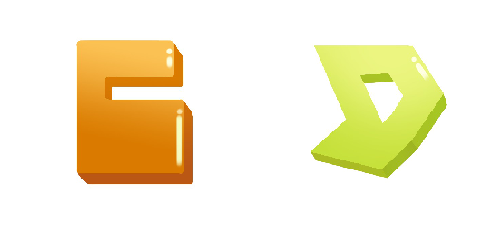



Similarity: 0.620


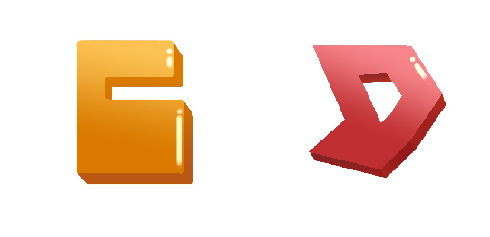



Similarity: 0.942


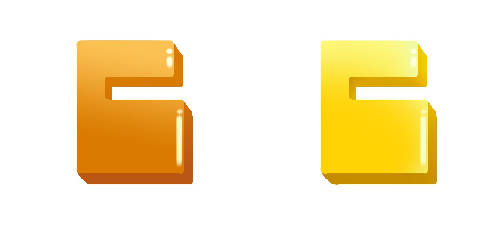



Similarity: 0.528


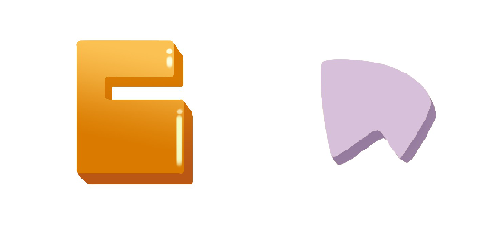



Similarity: 0.396


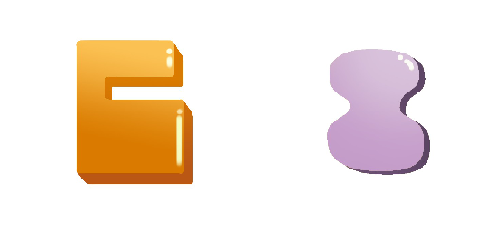



Similarity: 0.516


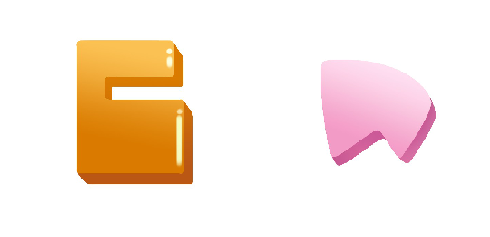



Similarity: 0.517


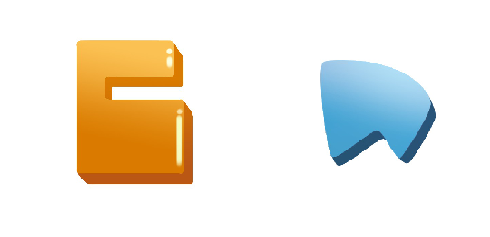



Similarity: 0.393


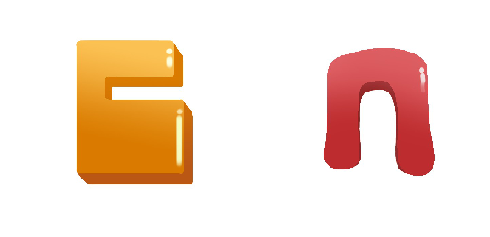



Similarity: 0.578


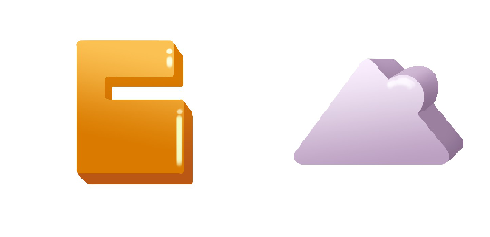



Similarity: 0.434


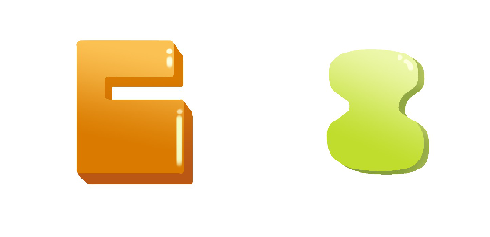



Similarity: 0.684


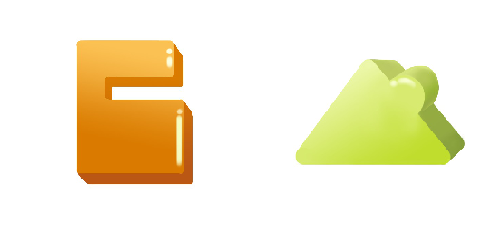



Similarity: 0.498


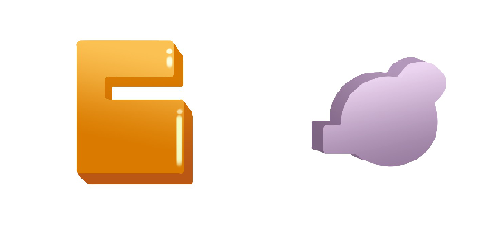



Similarity: 0.478


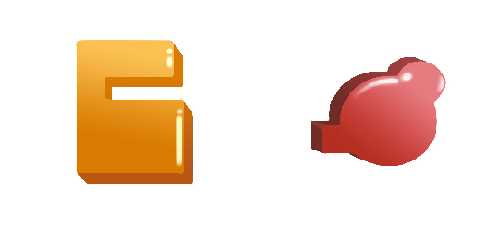



Similarity: 0.544


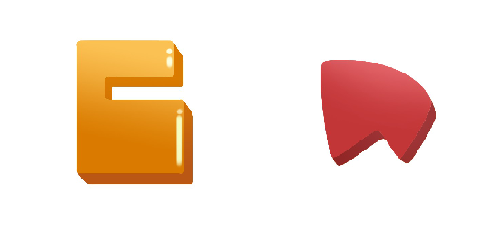



Similarity: 0.441


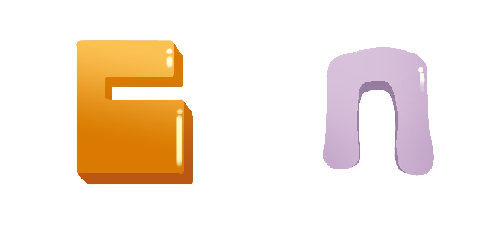

In [26]:
compare_similarities(X_artist_custom, X_artist_hidden, textures_artist, 0)

# Now make a function to compute bias strength for a given layer

In [54]:
def compute_avg_similarity(X_h, target, other1, other2):
    """
    Note: for now, 'other1' and 'other2' are unused.
    """
    scores = []
    for cat in set(target):
        # Find indices of samples with this category
        inds = list(np.where(target == cat)[0])
        scores_cat = [similarity(X_h[i], X_h[j]) for i, j in combinations(inds, 2)]
        scores.extend(scores_cat)
    
    return np.mean(scores)
    
def accuracy_for_layer(model, X_h, shapes, colors, textures, normalize=True):
    # Loop through the samples and compute accuracy
    sim_shape = compute_avg_similarity(X_h, target=shapes, other1=colors, other2=textures)
    sim_color = compute_avg_similarity(X_h, target=colors, other1=shapes, other2=textures)
    sim_texture = compute_avg_similarity(X_h, target=textures, other1=colors, other2=shapes)
    
    similarities = [sim_shape, sim_color, sim_texture]
    if normalize:
        similarities /= np.sum(similarities)
    return similarities

In [52]:
sim_shape_gen, sim_color_gen, sim_texture_gen = accuracy_for_layer(
    model, X_gen_hidden, shapes_gen, colors_gen, textures_gen, normalize=False
)
print('shape score: %0.3f' % sim_shape_gen)
print('color score: %0.3f' % sim_color_gen)
print('texture score: %0.3f' % sim_texture_gen)

shape score: 0.729
color score: 0.679
texture score: 0.795


In [53]:
sim_shape_artist, sim_color_artist, sim_texture_artist = accuracy_for_layer(
    model, X_artist_hidden, shapes_artist, colors_artist, textures_artist, normalize=False
)
print('shape score: %0.3f' % sim_shape_artist)
print('color score: %0.3f' % sim_color_artist)
print('texture score: %0.3f' % sim_texture_artist)

shape score: 0.771
color score: 0.562
texture score: 0.590


### update: try writing the function to only consider pairs w/ same x but different everything else

In [70]:
def compute_avg_similarity(X_h, target, other1, other2):
    scores = []
    for cat in set(target):
        print('Collecting scores for category #%i' % cat)
        # Find indices of samples with this category
        inds = list(np.where(target == cat)[0])
        scores_cat = []
        for i, j in combinations(inds, 2):
            assert target[i] == target[j]
            if not (other1[i] == other1[j] or other2[i] == other2[j]):
                scores_cat.append(similarity(X_h[i], X_h[j]))
        print('# scores for this category: %i' % len(scores_cat))
        scores.extend(scores_cat)
    
    return np.mean(scores)

def accuracy_for_layer(model, X_h, shapes, colors, textures, normalize=True):
    # Loop through the samples and compute accuracy
    print('Computing shape scores...')
    sim_shape = compute_avg_similarity(X_h, target=shapes, other1=colors, other2=textures)
    print('\nComputing color scores...')
    sim_color = compute_avg_similarity(X_h, target=colors, other1=shapes, other2=textures)
    print('\nComputing texture scores...')
    sim_texture = compute_avg_similarity(X_h, target=textures, other1=colors, other2=shapes)
    print('\n')
    
    similarities = [sim_shape, sim_color, sim_texture]
    if normalize:
        similarities /= np.sum(similarities)
    return similarities

In [71]:
sim_shape_gen, sim_color_gen, sim_texture_gen = accuracy_for_layer(
    model, X_gen_hidden, shapes_gen, colors_gen, textures_gen, normalize=False
)
print('shape score: %0.3f' % sim_shape_gen)
print('color score: %0.3f' % sim_color_gen)
print('texture score: %0.3f' % sim_texture_gen)

Computing shape scores...
# scores for this category: 51
# scores for this category: 47
# scores for this category: 49
# scores for this category: 48
# scores for this category: 49
# scores for this category: 49
# scores for this category: 47
# scores for this category: 50
# scores for this category: 50
# scores for this category: 48
# scores for this category: 47
# scores for this category: 40
# scores for this category: 45
# scores for this category: 47
# scores for this category: 48

Computing color scores...
# scores for this category: 47
# scores for this category: 46
# scores for this category: 48
# scores for this category: 46
# scores for this category: 42
# scores for this category: 48
# scores for this category: 48
# scores for this category: 40
# scores for this category: 48
# scores for this category: 44
# scores for this category: 48
# scores for this category: 48
# scores for this category: 47
# scores for this category: 51
# scores for this category: 48

Computing textur

In [75]:
sim_shape_artist, sim_color_artist, sim_texture_artist = accuracy_for_layer(
    model, X_artist_hidden, shapes_artist, colors_artist, textures_artist, normalize=False
)
print('shape score: %0.3f' % sim_shape_artist)
print('color score: %0.3f' % sim_color_artist)
print('texture score: %0.3f' % sim_texture_artist)

Computing shape scores...
# scores for this category: 34
# scores for this category: 51
# scores for this category: 35
# scores for this category: 40
# scores for this category: 18
# scores for this category: 5
# scores for this category: 11
# scores for this category: 18

Computing color scores...
# scores for this category: 33
# scores for this category: 50
# scores for this category: 30
# scores for this category: 18
# scores for this category: 41
# scores for this category: 7
# scores for this category: 45

Computing texture scores...
# scores for this category: 9
# scores for this category: 3
# scores for this category: 5
# scores for this category: 6
# scores for this category: 9
# scores for this category: 19
# scores for this category: 937


shape score: 0.705
color score: 0.511
texture score: 0.553


# Now compute layer-wise biases

In [14]:
def run_experiment(model, X, shapes, colors, textures, verbose=True):
    shape_vals = []
    color_vals = []
    texture_vals = []
    for i in range(len(model.layers)):
        # Compute hidden representations of the input for the specific hidden layer number
        X_h = compute_representations(model, X, i)
        # Compute layer accuracy
        sim_shape, sim_color, sim_texture = accuracy_for_layer(model, X_h, shapes, colors, textures, i)
        if verbose:
            print('Results for layer #%i:\n\t shape: %0.3f, color: %0.3f, texture: %0.3f' % 
                  (i, sim_shape, sim_color, sim_texture))
        shape_vals.append(sim_shape)
        color_vals.append(sim_color)
        texture_vals.append(sim_texture)
        
    return shape_vals, color_vals, texture_vals

### First, use the artificial generated images

In [169]:
shape_vals, color_vals, texture_vals = run_experiment(model, X_gen_vgg, shapes_gen, colors_gen, textures_gen)

Results for layer #0:
	 shape: 0.347, color: 0.324, texture: 0.330
Results for layer #1:
	 shape: 0.362, color: 0.304, texture: 0.334
Results for layer #2:
	 shape: 0.353, color: 0.312, texture: 0.335
Results for layer #3:
	 shape: 0.370, color: 0.297, texture: 0.333
Results for layer #4:
	 shape: 0.402, color: 0.263, texture: 0.335
Results for layer #5:
	 shape: 0.433, color: 0.229, texture: 0.338
Results for layer #6:
	 shape: 0.454, color: 0.220, texture: 0.327
Results for layer #7:
	 shape: 0.448, color: 0.220, texture: 0.332
Results for layer #8:
	 shape: 0.444, color: 0.227, texture: 0.330
Results for layer #9:
	 shape: 0.476, color: 0.202, texture: 0.323
Results for layer #10:
	 shape: 0.487, color: 0.201, texture: 0.311
Results for layer #11:
	 shape: 0.484, color: 0.203, texture: 0.313
Results for layer #12:
	 shape: 0.500, color: 0.201, texture: 0.299
Results for layer #13:
	 shape: 0.576, color: 0.166, texture: 0.258
Results for layer #14:
	 shape: 0.561, color: 0.178, textu

### Now try w/ artist images

In [2]:
#shape_vals1, color_vals1, texture_vals1 = run_experiment(model, X1, shapes1, colors1, textures1)
shape_vals1 = np.load('../results/bias_evaluation/vgg_artist_biases/shape_vals.npy')
color_vals1 = np.load('../results/bias_evaluation/vgg_artist_biases/color_vals.npy')
texture_vals1 = np.load('../results/bias_evaluation/vgg_artist_biases/texture_vals.npy')

In [44]:
# np.save('../data/images_brenden/shape_vals.npy', shape_vals1)
# np.save('../data/images_brenden/color_vals.npy', color_vals1)
# np.save('../data/images_brenden/texture_vals.npy', texture_vals1)

In [13]:
model.layers

In [3]:
#x_grid = list(range(len(model.layers)))
#labels = ['layer%0.2i'%i for i, _ in enumerate(x_grid)]
layers = ['Input', 'Conv1', 'Conv2', 'MaxPool1', 'Conv3', 'Conv4', 'MaxPool2',
          'Conv5', 'Conv6', 'Conv7', 'MaxPool3', 'Conv8', 'Conv9', 'Conv10', 
          'MaxPool4', 'Conv11', 'Conv12', 'Conv13', 'MaxPool5', 'Flatten',
          'Dense1', 'Dense2', 'Softmax']
x_grid = list(range(len(layers)))

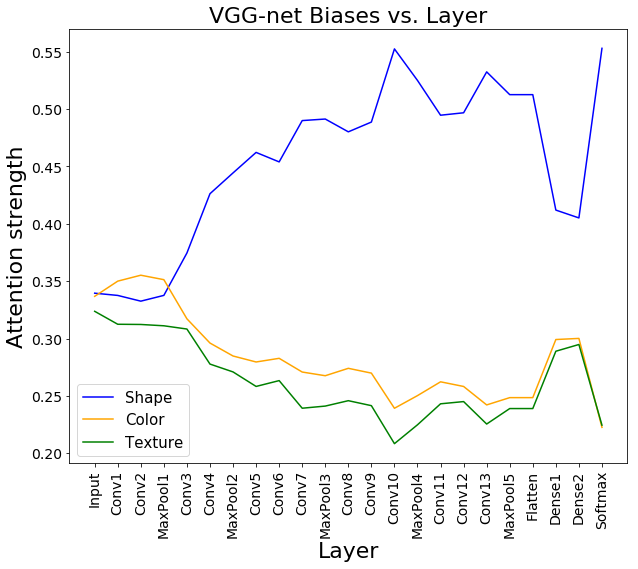

In [15]:
%matplotlib inline
import matplotlib.pylab as plt

plt.figure(figsize=(10,8))
plt.title('VGG-net Biases vs. Layer', fontsize=22)
plt.plot(x_grid, shape_vals1, label='Shape', color='blue')
plt.plot(x_grid, color_vals1, label='Color', color='orange')
plt.plot(x_grid, texture_vals1, label='Texture', color='green')
plt.yticks(fontsize=14)
plt.ylabel('Attention strength', fontsize=22)
plt.xticks(x_grid, layers, rotation='vertical', fontsize=14)
plt.xlabel('Layer', fontsize=22)
plt.legend(prop={'size': 15}, loc=3)
plt.show()

### Remove unneccesary layers

In [5]:
inds_keep = [1,2,4,5,7,8,9,11,12,13,15,16,17,20,21]
print([layers[i] for i in inds_keep])

['Conv1', 'Conv2', 'Conv3', 'Conv4', 'Conv5', 'Conv6', 'Conv7', 'Conv8', 'Conv9', 'Conv10', 'Conv11', 'Conv12', 'Conv13', 'Dense1', 'Dense2']


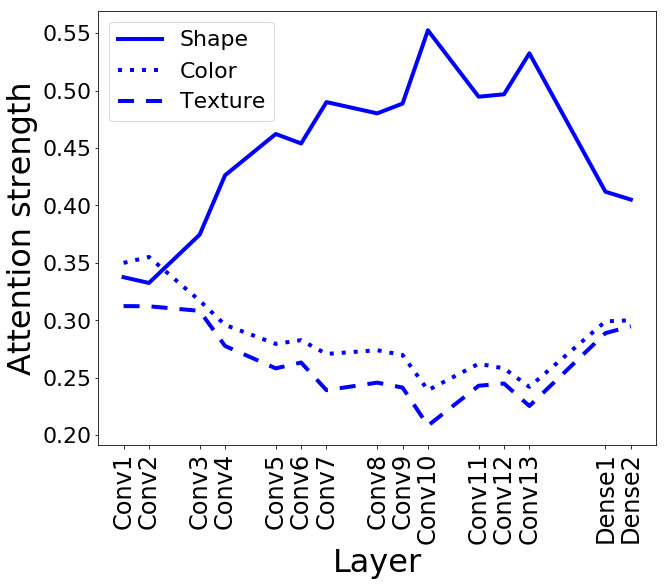

In [6]:
x_grid_1 = [x_grid[i] for i in inds_keep]
layers_1 = [layers[i] for i in inds_keep]
shape_vals1_1 = [shape_vals1[i] for i in inds_keep]
color_vals1_1 = [color_vals1[i] for i in inds_keep]
texture_vals1_1 = [texture_vals1[i] for i in inds_keep]

plt.figure(figsize=(10,8))
#plt.title('VGG-16 Layer-wise Biases', fontsize=32)
plt.plot(x_grid_1, shape_vals1_1, label='Shape', color='blue', linewidth=4)
plt.plot(x_grid_1, color_vals1_1, ls=(0, (1, 2)), label='Color', color='blue', linewidth=4)
plt.plot(x_grid_1, texture_vals1_1, ls=(0, (4, 3)), label='Texture', color='blue', linewidth=4)
plt.yticks(fontsize=22)
plt.ylabel('Attention strength', fontsize=32)
plt.xticks(x_grid_1, layers_1, rotation='vertical', fontsize=24)
plt.xlabel('Layer', fontsize=32)
plt.legend(prop={'size': 22}, loc=2)
plt.savefig(
    '/Users/reubenfeinman/Desktop/vgg_layer_biases.pdf',
    format='pdf',
    bbox_inches='tight'
)
# plt.savefig('/Users/reubenfeinman/Dropbox/NYU/fellowships/NSF/figures/layer-results-DNN.pdf', 
#             format='pdf',
#             bbox_inches='tight')

plt.show()

# Now create "hypothetical" fMRI results for the proposal

In [18]:
def normalize(shape_vals, color_vals, texture_vals):
    s = shape_vals + color_vals + texture_vals
    return shape_vals/s, color_vals/s, texture_vals/s

In [19]:
def get_others(shape_vals, scale=0.1):
    #shape_vals = np.random.normal(loc=shape_vals, scale=scale, size=shape_vals.shape)
    mean = (np.max(shape_vals) - shape_vals)
    color_vals = np.random.normal(loc=mean, scale=scale, size=shape_vals.shape)
    texture_vals = np.random.normal(loc=mean, scale=scale, size=shape_vals.shape)
    shape_vals, color_vals, texture_vals = normalize(shape_vals, color_vals, texture_vals)
    
    #texture_vals = 1 - shape_vals - color_vals
    return shape_vals, color_vals, texture_vals

In [22]:
from scipy.special import expit

grid = np.linspace(-4, 4, 15)
shape_bias_brain1 = expit(grid)
shape_bias_brain1, color_bias_brain1, texture_bias_brain1 = get_others(shape_bias_brain1, scale=0.03)

In [23]:
shape_bias_brain2 = 0.5*np.ones(15,)
shape_bias_brain2, color_bias_brain2, texture_bias_brain2 = get_others(shape_bias_brain2, scale=0.03)

In [24]:
grid1 = np.linspace(1, 10000, 15)
shape_bias_brain3 = np.power(grid1,1/10)
shape_bias_brain3, color_bias_brain3, texture_bias_brain3 = get_others(shape_bias_brain3, scale=0.1)
# plt.figure()
# plt.plot(grid1, shape_bias_brain3)
# plt.show()

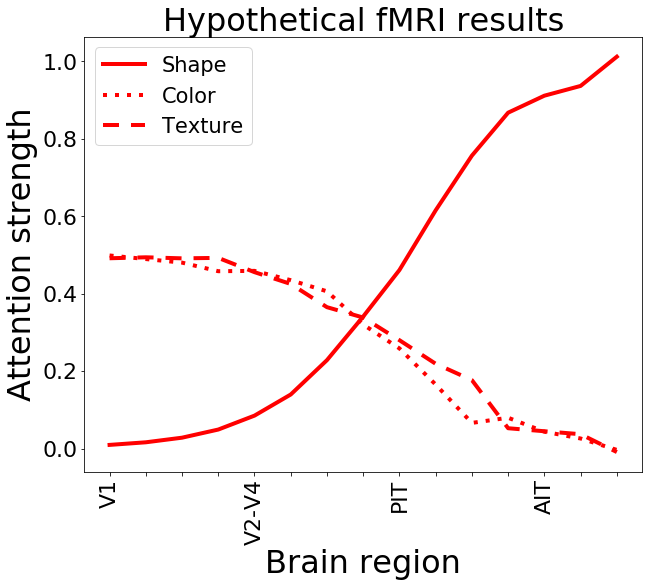

In [41]:
from scipy.special import expit

grid = np.linspace(-4, 4, 15)
layers_brain = ['V1', '', '', '',
                'V2-V4', '', '', '', 
                'PIT', '', '', '',
                'AIT']

plt.figure(figsize=(10,8))
plt.title('Hypothetical fMRI results', fontsize=32)
# 1
plt.plot(grid, shape_bias_brain1, color='red', linewidth=4, label='Shape')
plt.plot(grid, color_bias_brain1, ls=(0, (1, 2)), color='red', linewidth=4, label='Color')
plt.plot(grid, texture_bias_brain1, ls=(0, (4, 3)), color='red', linewidth=4, label='Texture')
# # 2
# plt.plot(grid, shape_bias_brain2, color='purple', linewidth=4, label='2?')
# plt.plot(grid, color_bias_brain2, ls=(0, (1, 2)), color='purple', linewidth=4)
# plt.plot(grid, texture_bias_brain2, ls=(0, (4, 3)), color='purple', linewidth=4)
# # 3
# plt.plot(grid, shape_bias_brain3, color='green', linewidth=4, label='3?')
# plt.plot(grid, color_bias_brain3, ls=(0, (1, 2)), color='green', linewidth=4)
# plt.plot(grid, texture_bias_brain3, ls=(0, (4, 3)), color='green', linewidth=4)
plt.yticks(fontsize=22)
plt.ylabel('Attention strength', fontsize=32)
plt.xticks(grid, layers_brain, rotation='vertical', fontsize=22)
plt.xlabel('Brain region', fontsize=32)
plt.legend(prop={'size': 21}, loc=2)
plt.savefig('/Users/reubenfeinman/Dropbox/NYU/fellowships/NSF/figures/layer-results-brain.pdf', 
            format='pdf',
            bbox_inches='tight')
plt.show()